In [30]:
from pathlib import Path
from tifffile import imread, imwrite
import numpy as np
import sys
import json
sys.path.append("../")
from utils import *
from plots import *

In [31]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/TRAINING"
gt_path = DATA_PATH / "dataset_float32/labels/semantic"

folds = 3
# stardist_path = Path("E:/Code/CELLSEG_BENCHMARK/SUPERVISED_PERF_FIG/TRAINING").resolve()
# models_pred_path = [(stardist_path / f"fold{i+1}").resolve() for i in range(folds)] 
models_pred_path = [(DATA_PATH / f"fold{i+1}").resolve() for i in range(folds)] 

In [3]:
gt_images = {}
# load images in gt_path
for img_path in gt_path.glob("*.tif"):
    img = imread(img_path)
    gt_images[img_path.stem[:2]] = img

In [4]:
print("Auto-estimated thresholds:")
path_jsons = [DATA_PATH / f"../weights/fold_{i+1}/stardist/thresholds.json" for i in range(folds)]
for i, path_json in enumerate(path_jsons):
    with open(path_json, 'r') as f:
        thresholds = json.load(f)
        print(f"Fold {i+1}")
        for key, value in thresholds.items():
            print(f"{key}: {value}")

Auto-estimated thresholds:
Fold 1
prob: 0.638932075449858
nms: 0.3
Fold 2
prob: 0.47447843164827164
nms: 0.3
Fold 3
prob: 0.5183999443597114
nms: 0.3


In [5]:
# for each fold and model, the goal is to compute what is the best threshold for the model, based on Dice between the GT and the prediction
dices_df = pd.DataFrame(columns=["Image", "Threshold", "NMS", "Dice", "Fold"])
for model_pred_path in models_pred_path:
    print("Fold : ", model_pred_path.name)
    preds_path = model_pred_path / "stardist" 
    for i, img_path in enumerate(preds_path.glob("*.tif")):
        img_name = img_path.stem
        print(f"Image: {img_name[:2]}")
        img = imread(img_path)
        gt = gt_images[img_name[:2]]
        nms = float(img_path.stem.split("_nms_")[1].split("_prob_")[0])
        prob_thresh = float(img_path.stem.split("_prob_")[1])
        print("Threshold: ", prob_thresh)
        print("NMS: ", nms)
        # gt = np.where(gt > 0, 1, 0) 3 already semantic
        pred = np.where(img > 0, 1, 0)
        dice = dice_coeff(y_true=gt, y_pred=pred)
        dices_df.loc[len(dices_df.index)] = [img_name[:2], prob_thresh, nms, dice, model_pred_path.name]

Fold :  fold1
Image: c1
Threshold:  0.1
NMS:  0.1
Image: c1
Threshold:  0.2
NMS:  0.1
Image: c1
Threshold:  0.3
NMS:  0.1
Image: c1
Threshold:  0.4
NMS:  0.1
Image: c1
Threshold:  0.5
NMS:  0.1
Image: c1
Threshold:  0.6
NMS:  0.1
Image: c1
Threshold:  0.7
NMS:  0.1
Image: c1
Threshold:  0.8
NMS:  0.1
Image: c1
Threshold:  0.9
NMS:  0.1
Image: c1
Threshold:  0.1
NMS:  0.2
Image: c1
Threshold:  0.2
NMS:  0.2
Image: c1
Threshold:  0.3
NMS:  0.2
Image: c1
Threshold:  0.4
NMS:  0.2
Image: c1
Threshold:  0.5
NMS:  0.2
Image: c1
Threshold:  0.6
NMS:  0.2
Image: c1
Threshold:  0.7
NMS:  0.2
Image: c1
Threshold:  0.8
NMS:  0.2
Image: c1
Threshold:  0.9
NMS:  0.2
Image: c1
Threshold:  0.1
NMS:  0.3
Image: c1
Threshold:  0.2
NMS:  0.3
Image: c1
Threshold:  0.3
NMS:  0.3
Image: c1
Threshold:  0.4
NMS:  0.3
Image: c1
Threshold:  0.5
NMS:  0.3
Image: c1
Threshold:  0.6
NMS:  0.3
Image: c1
Threshold:  0.7
NMS:  0.3
Image: c1
Threshold:  0.8
NMS:  0.3
Image: c1
Threshold:  0.9
NMS:  0.3
Image: c1
Thre

In [6]:
dices_df.sort_values(by="Threshold", inplace=True)
dices_df

,Image,Threshold,NMS,Dice,Fold
0,c1,0.1,0.1,0.487222,fold1
414,c1,0.1,0.2,0.668829,fold2
423,c1,0.1,0.3,0.667410,fold2
432,c1,0.1,0.4,0.664397,fold2
441,c1,0.1,0.5,0.659236,fold2
...,...,...,...,...,...
368,c5,0.9,0.5,0.557422,fold1
170,c3,0.9,0.1,0.463814,fold1
692,c4,0.9,0.5,0.098401,fold2
701,c4,0.9,0.6,0.098401,fold2


In [7]:
dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

C:\Users\Cyril\AppData\Local\Temp\ipykernel_17608\971282983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])


,Image,Threshold,NMS,Dice,Fold
Fold,,,,,
fold1,c5,0.8,0.5,0.560387,fold1
fold2,vi,0.5,0.7,0.690538,fold2
fold3,c5,0.6,0.4,0.628781,fold3


In [8]:
# show 3 best Dice for each fold
dices_df.groupby("Fold").apply(lambda x: x.nlargest(3, "Dice"))

C:\Users\Cyril\AppData\Local\Temp\ipykernel_17608\327610266.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dices_df.groupby("Fold").apply(lambda x: x.nlargest(3, "Dice"))


Image  Threshold  NMS      Dice   Fold
Fold                                             
fold1 367     c5        0.8  0.5  0.560387  fold1
      376     c5        0.8  0.6  0.560232  fold1
      385     c5        0.8  0.7  0.559902  fold1
fold2 787     vi        0.5  0.7  0.690538  fold2
      778     vi        0.5  0.6  0.689971  fold2
      797     vi        0.6  0.8  0.688972  fold2
fold3 1085    c5        0.6  0.4  0.628781  fold3
      1112    c5        0.6  0.7  0.628514  fold3
      1094    c5        0.6  0.5  0.628482  fold3

In [9]:
dices_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
0.7    0.588143
0.6    0.584936
0.8    0.581035
0.5    0.580061
0.4    0.578568
Name: Dice, dtype: float64

In [10]:
dices_df.groupby("NMS").Dice.median().sort_values(ascending=False).head(5)

NMS
0.3    0.577664
0.2    0.576149
0.4    0.574726
0.1    0.572930
0.5    0.570971
Name: Dice, dtype: float64

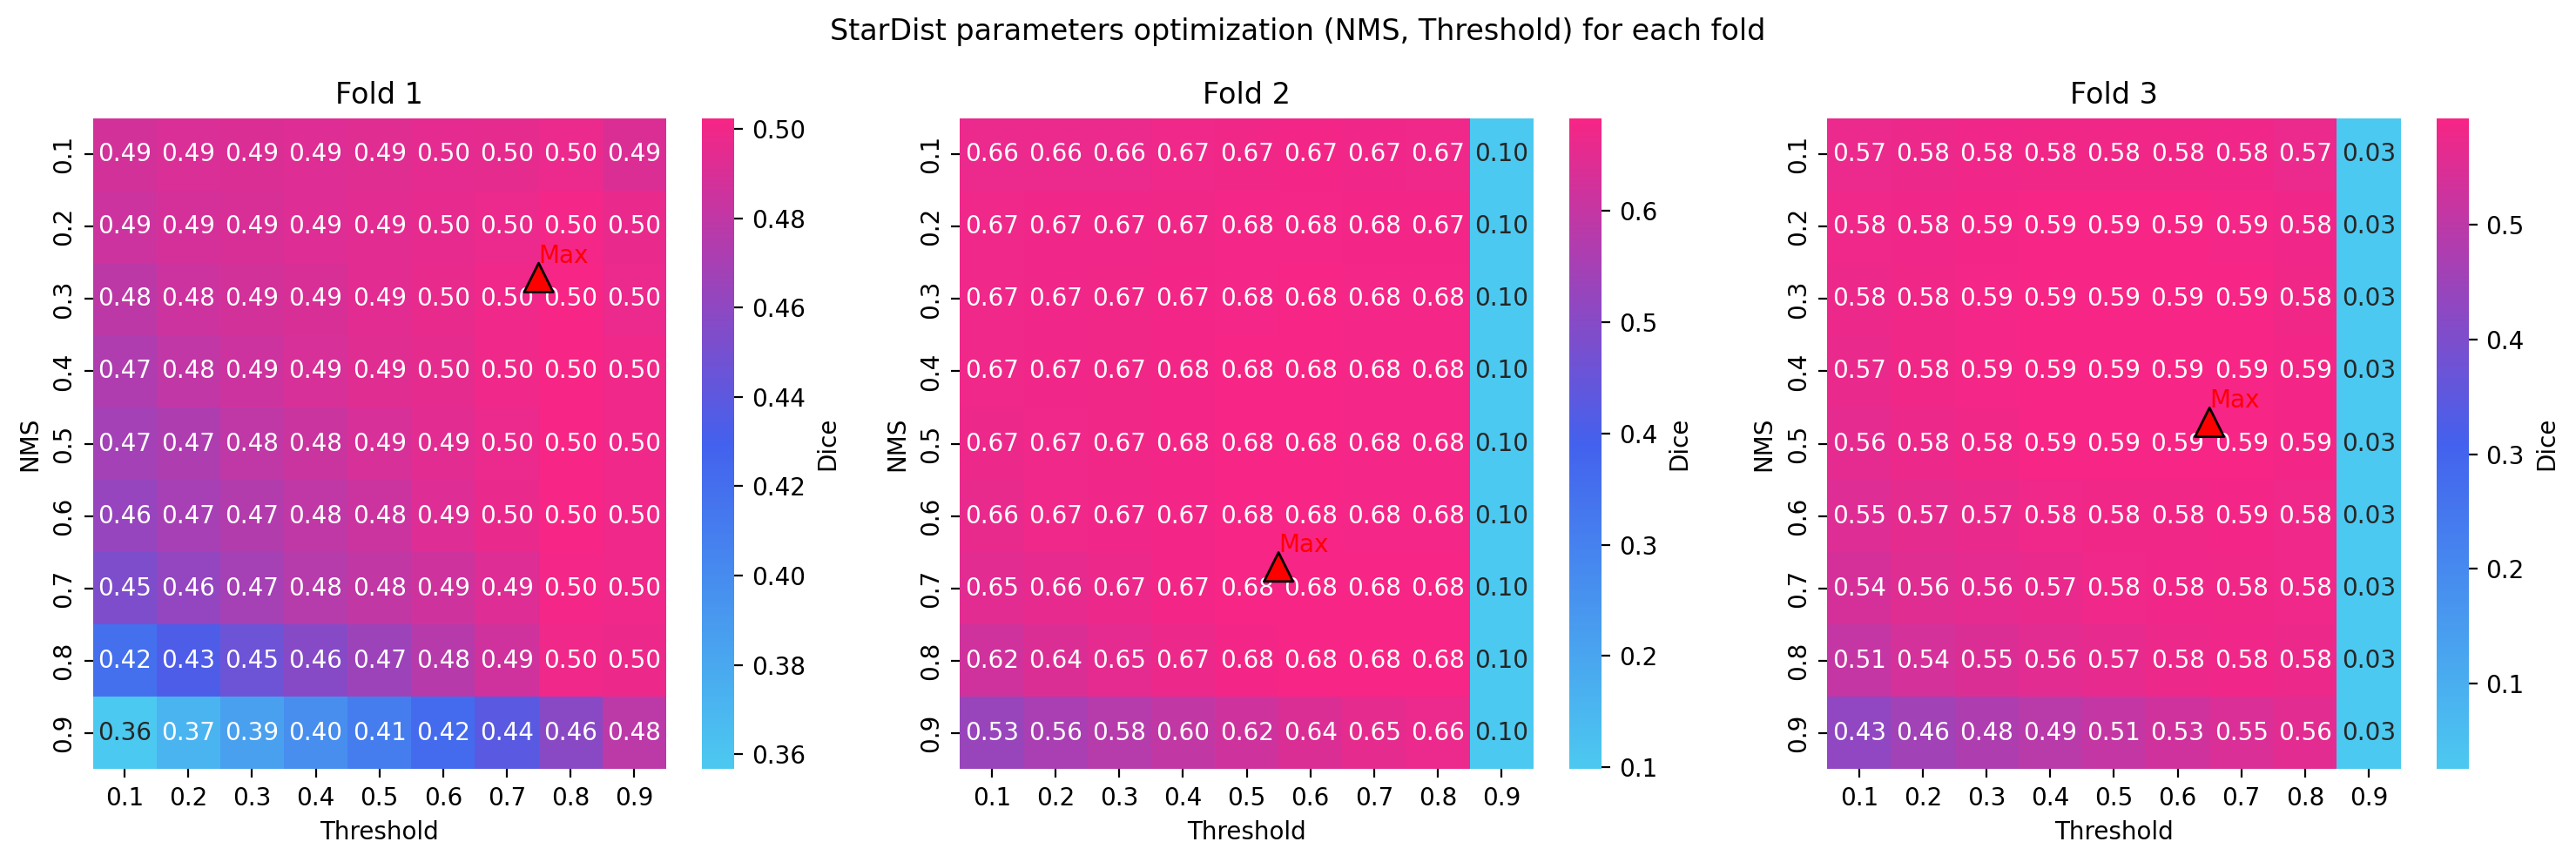

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=DPI)
for i in range(folds):
    # Group by 'NMS' and 'Threshold' and calculate the mean of 'Dice' for fold i
    grouped_df = dices_df[dices_df['Fold'] == f"fold{i+1}"].groupby(['NMS', 'Threshold'])['Dice'].median().reset_index()

    pivot_df = grouped_df.pivot(index='NMS', columns='Threshold', values='Dice')
    max_coords = np.where(pivot_df == pivot_df.max().max())
    sns.heatmap(pivot_df, cmap=SEQUENTIAL_COLORMAP, annot=True, fmt=".2f", cbar_kws={'label': 'Dice'}, ax=axs[i])
    # Annotate the maximum value
    axs[i].annotate('Max', xy=(max_coords[1][0], max_coords[0][0]), xytext=(max_coords[1][0], max_coords[0][0]),
                arrowprops=dict(facecolor='red', shrink=0.05), color='red')
    axs[i].set_title(f"Fold {i+1}")
plt.suptitle("StarDist parameters optimization (NMS, Threshold) for each fold")
plt.tight_layout()
plt.show()

In [ ]:
images = []

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


model_stats = []
names_stats = []

for i, p in enumerate(images):
    print(f"Validating on {names[i]}")
    if len(p.shape) > 3:
        p = p[0].astype(np.uint64)
    stats = [matching_dataset(
        GT_labels, 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    for t in taus:
        names_stats.append(names[i])
    # uncomment for ALL plots : 
    # plot_performance(taus, stats, name=names[i])
    print("*"*20)

Validating on stardist_nms_0.2_prob_0.1
********************
Validating on stardist_nms_0.2_prob_0.2
********************
Validating on stardist_nms_0.2_prob_0.3
********************
Validating on stardist_nms_0.2_prob_0.4
********************
Validating on stardist_nms_0.2_prob_0.5
********************
Validating on stardist_nms_0.2_prob_0.6
********************
Validating on stardist_nms_0.2_prob_0.7
********************
Validating on stardist_nms_0.2_prob_0.8
********************
Validating on stardist_nms_0.2_prob_0.9
********************
Validating on stardist_nms_0.2_prob_1.0
********************
Validating on stardist_nms_0.3_prob_0.1
********************
Validating on stardist_nms_0.3_prob_0.2
********************
Validating on stardist_nms_0.3_prob_0.3
********************
Validating on stardist_nms_0.3_prob_0.4
********************
Validating on stardist_nms_0.3_prob_0.5
********************
Validating on stardist_nms_0.3_prob_0.6
********************
Validating on stardist_n

In [ ]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Params"] = names_stats
df

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Params
thresh,,,,,,,,,,,,,,,
0.1,iou,2741,3169,216,0.536210,0.936189,0.517303,0.681872,3385,5910,0.307480,0.328438,0.223953,False,stardist_nms_0.2_prob_0.1
0.2,iou,3126,2784,601,0.471066,0.822452,0.427584,0.599032,3385,5910,0.288920,0.351292,0.210435,False,stardist_nms_0.2_prob_0.1
0.3,iou,4138,1772,1613,0.299831,0.523486,0.235544,0.381280,3385,5910,0.214658,0.410056,0.156346,False,stardist_nms_0.2_prob_0.1
0.4,iou,5110,800,2585,0.135364,0.236337,0.094173,0.172136,3385,5910,0.115650,0.489342,0.084233,False,stardist_nms_0.2_prob_0.1
0.5,iou,5610,300,3085,0.050761,0.088626,0.033352,0.064551,3385,5910,0.051471,0.580768,0.037489,False,stardist_nms_0.2_prob_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.5,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.4_prob_1.0
0.6,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.4_prob_1.0
0.7,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.4_prob_1.0


In [ ]:
df.sort_values(by="f1", ascending=False)

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Params
thresh,,,,,,,,,,,,,,,
0.1,iou,1677,2973,412,0.639355,0.878287,0.587317,0.740012,3385,4650,0.279112,0.317791,0.235170,False,stardist_nms_0.4_prob_0.7
0.1,iou,1524,2868,517,0.653005,0.847267,0.584233,0.737559,3385,4392,0.268874,0.317343,0.234059,False,stardist_nms_0.4_prob_0.8
0.1,iou,1626,2924,461,0.642637,0.863811,0.583516,0.736988,3385,4550,0.275356,0.318769,0.234929,False,stardist_nms_0.3_prob_0.7
0.1,iou,1586,2883,502,0.645111,0.851699,0.579964,0.734148,3385,4469,0.272440,0.319879,0.234838,False,stardist_nms_0.2_prob_0.7
0.1,iou,1863,3036,349,0.619718,0.896898,0.578506,0.732979,3385,4899,0.287000,0.319992,0.234547,False,stardist_nms_0.4_prob_0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.6,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.3_prob_1.0
0.7,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.3_prob_1.0
0.8,iou,0,0,3385,0.000000,0.000000,0.000000,0.000000,3385,0,0.000000,0.000000,0.000000,False,stardist_nms_0.3_prob_1.0


In [ ]:
# get cellpose_count first color of tab20 as rgb hex
# sd_color = get_n_shades(COLORMAP[0], n_shades=cellpose_count)
# colormap = sd_color + [COLORMAP[2], COLORMAP[3]]
colormap = "tab20"

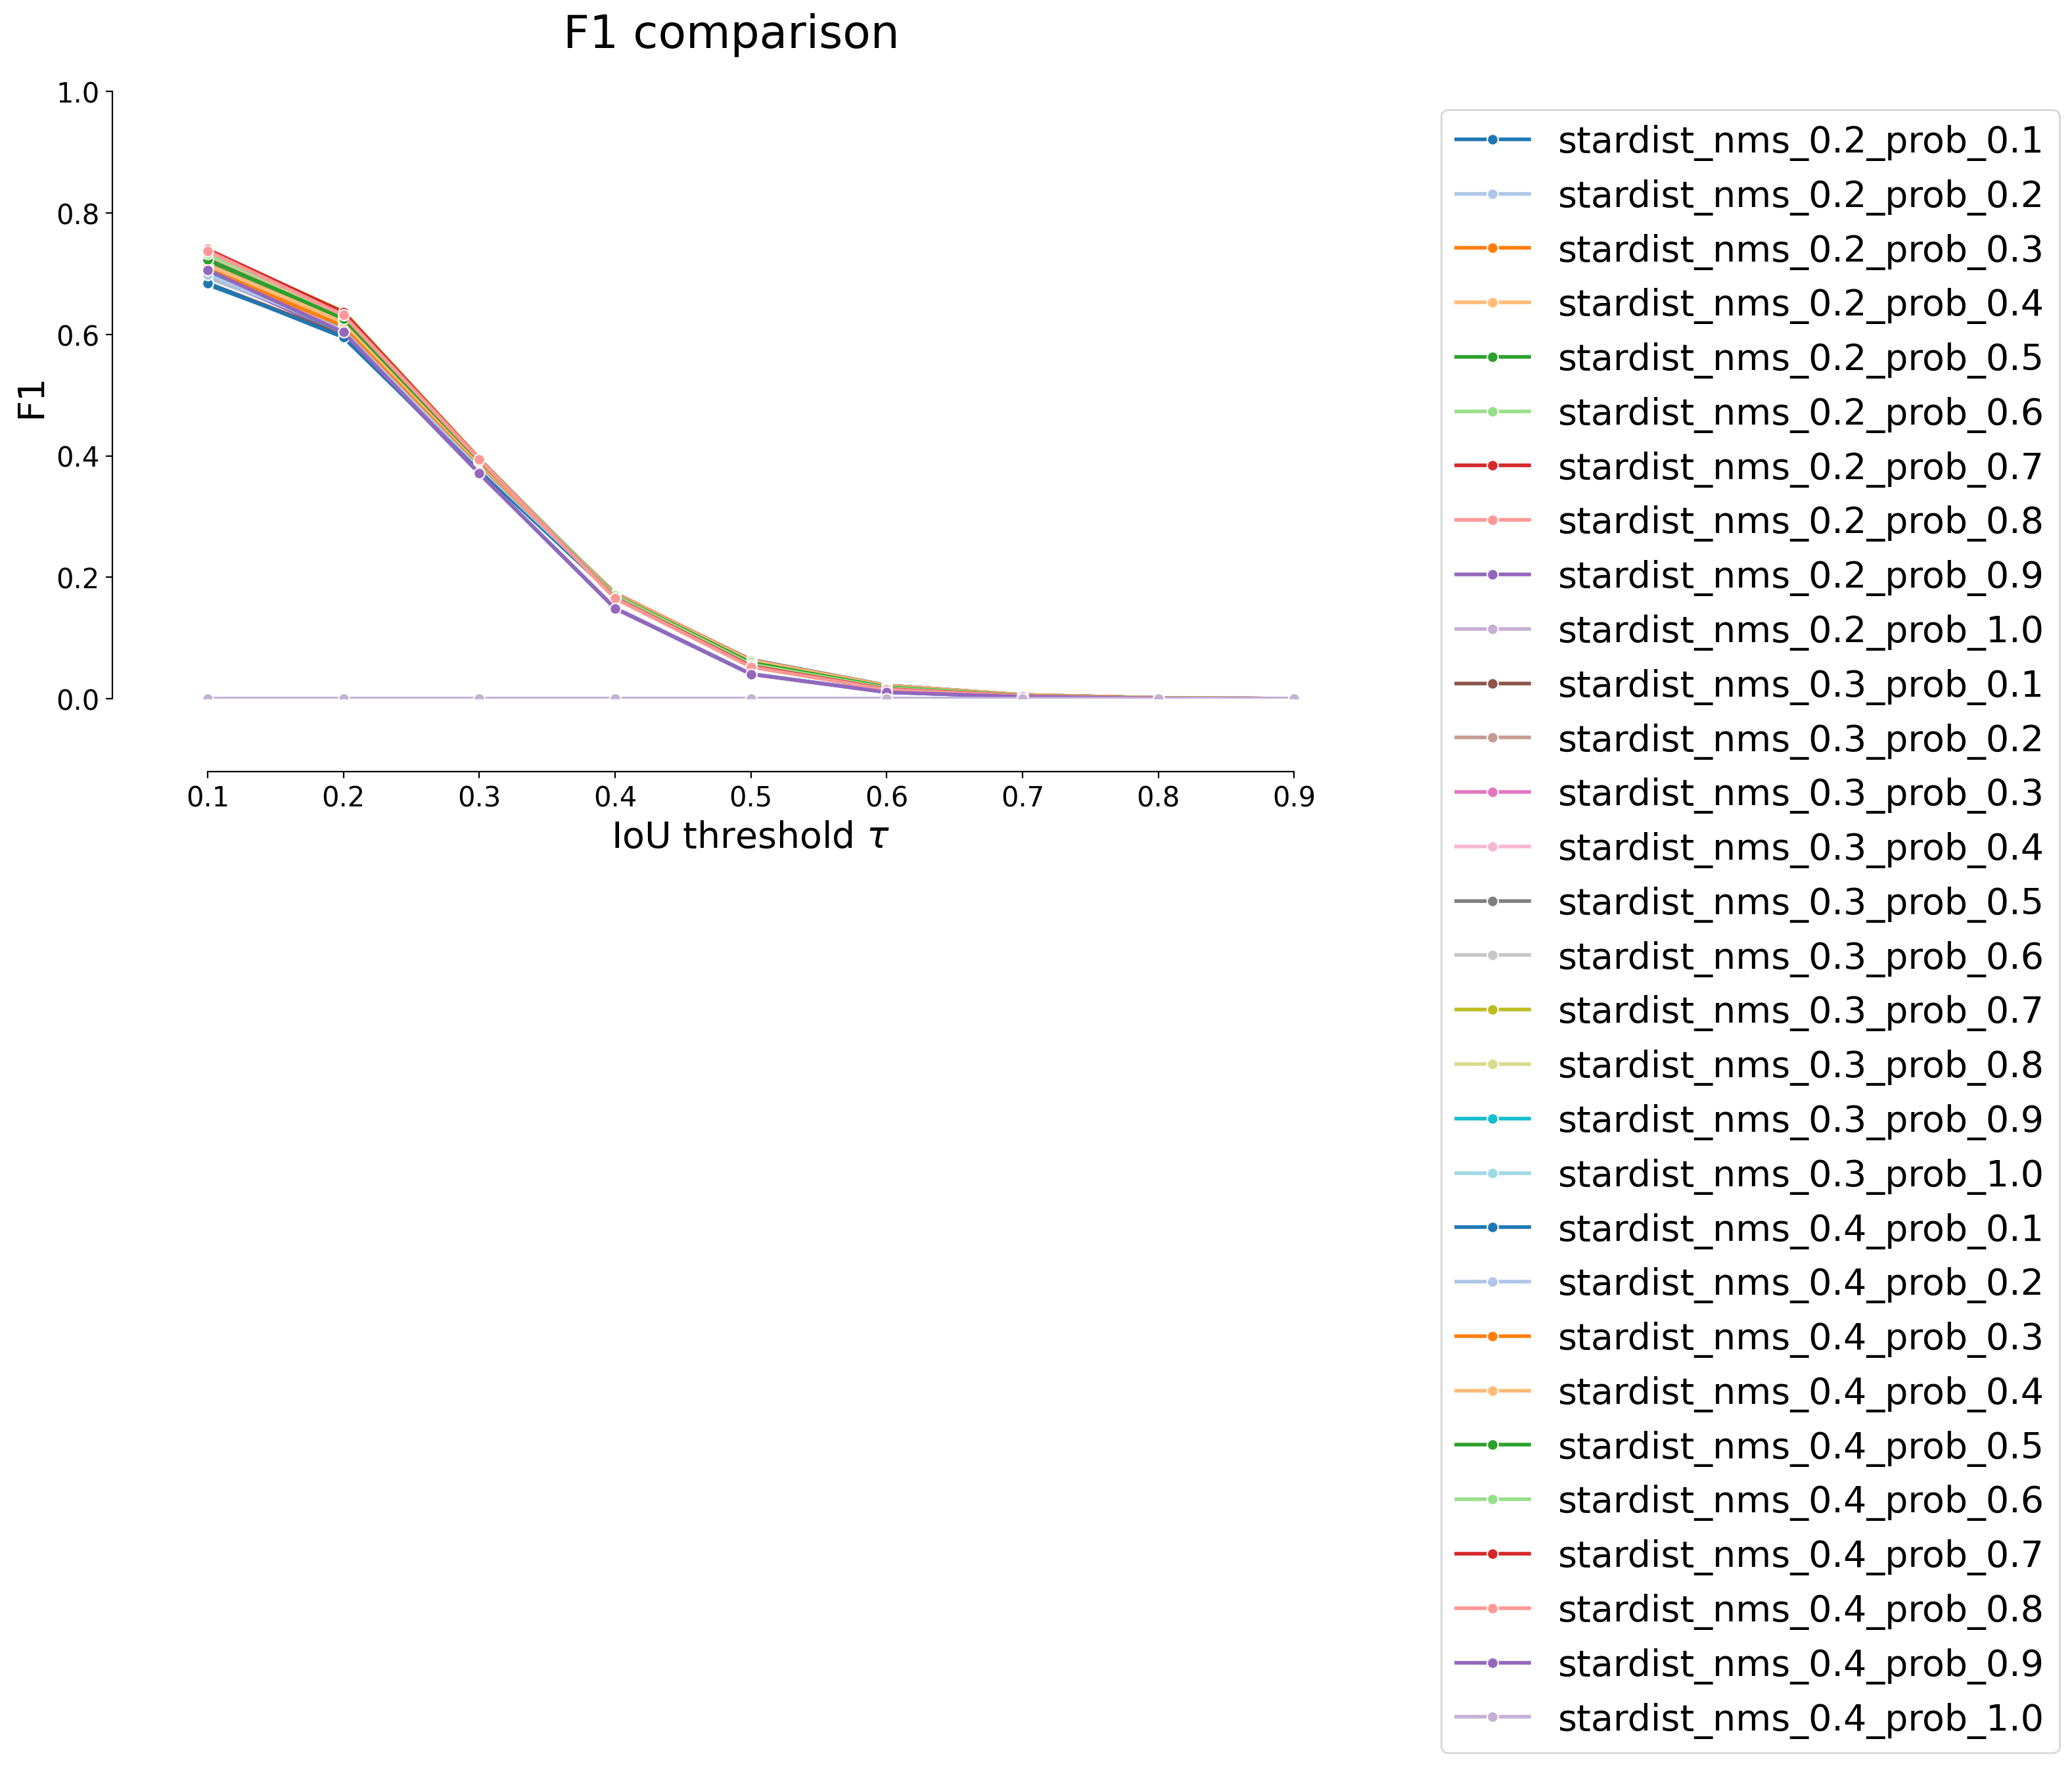

In [ ]:
plot_stat_comparison(taus=taus, stats_list=model_stats, model_names=names, metric="IoU", colormap=colormap)
if SAVE_AS_PNG:
    plt.savefig(f"sd_hyperparams_test_iou.png", format="png")
if SAVE_AS_SVG:
    plt.savefig(f"sd_hyperparams_test_iou.svg", format="svg", bbox_inches='tight')